# Forecasting Stock Volume

In this example, we will be forecasting the volume of different Dow Jones stocks for a given day.  The data used is a public Kaggle dataset consisting of stock market data for the DJIA 30: [DJIA Stock Data](https://www.kaggle.com/szrlee/stock-time-series-20050101-to-20171231).

We will be using Sparkling Water to ingest the data and add historical lags.

Our Machine Learning Workflow is: 

1. Import data into Spark
2. Feature engineering
   * Add time lag columns
3. Train a single DRF model
4. Examine DRF model
5. Run AutoML (from Python)
6. Watch AutoML progress (in the H2O Flow Web UI)

# Step 1 (of 6).  Import data into Spark

In [1]:
# Initiate H2OContext on top of Spark

from pysparkling import *
hc = H2OContext.getOrCreate(spark)

Connecting to H2O server at http://172.31.98.72:54321... successful.


H2O cluster uptime:,12 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.4
H2O cluster version age:,7 months !!!
H2O cluster name:,sparkling-water-kyanyoga_local-1539114729136
H2O cluster total nodes:,1
H2O cluster free memory:,749 Mb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"



Sparkling Water Context:
 * H2O name: sparkling-water-kyanyoga_local-1539114729136
 * cluster size: 1
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (driver,172.31.98.72,54321)
  ------------------------

  Open H2O Flow in browser: http://172.31.98.72:54321 (CMD + click in Mac OSX)

    


In [4]:
# Import data

from pyspark.sql.types import *

schema = StructType([StructField("Date", TimestampType(), True),
                     StructField("Open", DoubleType(), True),
                     StructField("High", DoubleType(), True),
                     StructField("Low", DoubleType(), True),
                     StructField("Close", DoubleType(), True),
                     StructField("Volume", DoubleType(), True),
                     StructField("Name", StringType(), True)])

# https://s3.amazonaws.com/h2o-training/events/h2o_world/TimeSeries/all_stocks_2006-01-01_to_2018-01-01.csv
stock_df = spark.read.csv("../data/all_stocks_2006-01-01_to_2018-01-01.csv", header = True, schema = schema)

In [5]:
stock_df.head(5)

[Row(Date=datetime.datetime(2006, 1, 3, 0, 0), Open=77.76, High=79.35, Low=77.24, Close=79.11, Volume=3117200.0, Name=u'MMM'),
 Row(Date=datetime.datetime(2006, 1, 4, 0, 0), Open=79.49, High=79.49, Low=78.25, Close=78.71, Volume=2558000.0, Name=u'MMM'),
 Row(Date=datetime.datetime(2006, 1, 5, 0, 0), Open=78.41, High=78.65, Low=77.56, Close=77.99, Volume=2529500.0, Name=u'MMM'),
 Row(Date=datetime.datetime(2006, 1, 6, 0, 0), Open=78.64, High=78.9, Low=77.64, Close=78.63, Volume=2479500.0, Name=u'MMM'),
 Row(Date=datetime.datetime(2006, 1, 9, 0, 0), Open=78.5, High=79.83, Low=78.46, Close=79.02, Volume=1845600.0, Name=u'MMM')]

# Step 2 (of 6).  Feature Engineering

We will add new features to our data that can help predict the Volume for a given company.  Features that tell us:
* what was the Volume for a company yesterday, two days ago, three days ago?  
* what was the Close price, Open price, High price, Low price for a company yesterday?

can be very predictive in forecasting.  To create these features we will use PySpark's window function.

In [6]:
## Add Volume from the Previous Day, Previous 2 days, Previous 3 days per Company
from pyspark.sql.functions import lag, col
from pyspark.sql.window import Window

w = Window().partitionBy(col("Name")).orderBy(col("Date"))
ext_stock_df = stock_df.select("*", lag("Volume", count = 1).over(w).alias("Volume_lag1"),
               lag("Volume", count = 2).over(w).alias("Volume_lag2"),
               lag("Volume", count = 3).over(w).alias("Volume_lag3")).na.drop()

In [7]:
ext_stock_df.show()

+-------------------+-----+-----+-----+-----+---------+----+-----------+-----------+-----------+
|               Date| Open| High|  Low|Close|   Volume|Name|Volume_lag1|Volume_lag2|Volume_lag3|
+-------------------+-----+-----+-----+-----+---------+----+-----------+-----------+-----------+
|2006-01-06 00:00:00|78.64| 78.9|77.64|78.63|2479500.0| MMM|  2529500.0|  2558000.0|  3117200.0|
|2006-01-09 00:00:00| 78.5|79.83|78.46|79.02|1845600.0| MMM|  2479500.0|  2529500.0|  2558000.0|
|2006-01-10 00:00:00| 79.0|79.01|78.08|78.53|1919900.0| MMM|  1845600.0|  2479500.0|  2529500.0|
|2006-01-11 00:00:00|78.44|78.66|77.84|78.37|1911900.0| MMM|  1919900.0|  1845600.0|  2479500.0|
|2006-01-12 00:00:00| 78.2|78.23| 77.2| 77.7|2121100.0| MMM|  1911900.0|  1919900.0|  1845600.0|
|2006-01-13 00:00:00|76.95| 78.2|76.95| 77.5|1925300.0| MMM|  2121100.0|  1911900.0|  1919900.0|
|2006-01-17 00:00:00| 77.1|77.62| 77.0|77.09|2073400.0| MMM|  1925300.0|  2121100.0|  1911900.0|
|2006-01-18 00:00:00| 77.0|77.

In [8]:
## Add Close, Open, Low, and High by Company for Previous day per Company

ext_stock_df = ext_stock_df.select("*", lag("Close", count = 1).over(w).alias("Close_lag1")).na.drop()
ext_stock_df = ext_stock_df.select("*", lag("Low", count = 1).over(w).alias("Low_lag1")).na.drop()
ext_stock_df = ext_stock_df.select("*", lag("High", count = 1).over(w).alias("High_lag1")).na.drop()
ext_stock_df = ext_stock_df.select("*", lag("Open", count = 1).over(w).alias("Open_lag1")).na.drop()

In [9]:
## Convert Spark DataFrame to H2O Frame

import h2o
ext_stock_hf = hc.as_h2o_frame(ext_stock_df, "stockWithLagsTable")

In [10]:
## Convert strings to categoricals

ext_stock_hf["Name"] = ext_stock_hf["Name"].asfactor()

# Step 3 (of 6).  Train a single DRF model

We will train a random forest model with our added lag features as predictors.

In [11]:
# Set Predictors
predictors = list(set(ext_stock_hf.col_names) - set(["Volume", "Open", "Close", "High", "Low"]))
response = "Volume"

In [12]:
# Split data into training and testing by time
# Test data is the last day of data

is_test = (ext_stock_hf["Date"].year() == 2017) & \
          (ext_stock_hf["Date"].month() == 12) & \
          (ext_stock_hf["Date"].day() == 29)

train = ext_stock_hf[is_test == 0]
test = ext_stock_hf[is_test == 1]

In [13]:
# Train Random Forest

from h2o.estimators import H2ORandomForestEstimator
drf_model = H2ORandomForestEstimator(model_id = "drf_model.hex",
                                     seed = 1234,
                                     ntrees = 5)
drf_model.train(x = predictors,
                y = response,
                training_frame = train,
                validation_frame = test)

drf Model Build progress: |███████████████████████████████████████████████| 100%


# Step 4 (of 6).  Examine DRF model

The Mean Absolute Percent Error is about 20% on our test data.

In [14]:
preds = drf_model.predict(test)
mape = ((test["Volume"] - preds).abs()/test["Volume"]).mean()[0]
print("Mean Absolute Percent Error: " + "{0:.0f}%".format(100*mape))

drf prediction progress: |████████████████████████████████████████████████| 100%
Mean Absolute Percent Error: 24%


The graph below shows the variable importance for the random forest model.  The most important predictors are the volume lags.  We can use the partial dependency plots to see the relationship between these features and the model's prediction.

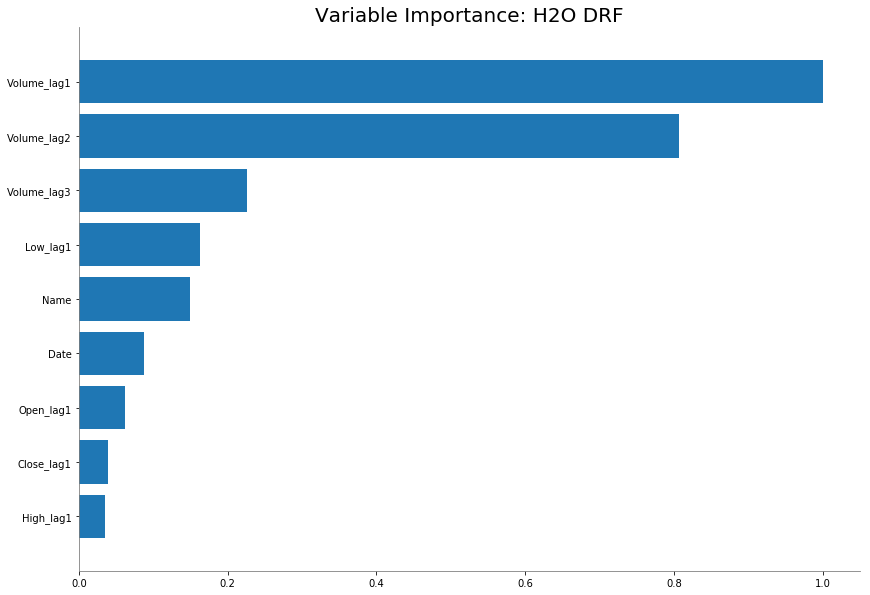

In [15]:
%matplotlib inline
drf_model.varimp_plot()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


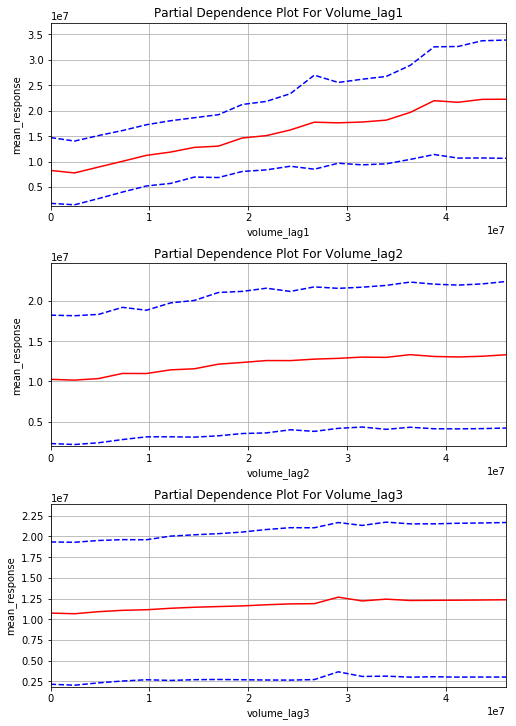

In [16]:
# Filter data to common volume
max_volume = train["Volume"].quantile(prob = [0.9])[0, 1]
pdp_data = train[(train["Volume_lag1"] < max_volume) & 
                 (train["Volume_lag2"] < max_volume) & 
                 (train["Volume_lag3"] < max_volume) ]
# create pdp's
pdps = drf_model.partial_plot(data = pdp_data, cols = ["Volume_lag1", "Volume_lag2", "Volume_lag3"])

The partial plots show that the Volume trend tracks the Volume values from the previous days for the company.

# Step 5 (of 6).  Run AutoML

Now we can try running AutoML to see if we can improve the results even further.

In [20]:
from h2o.automl import H2OAutoML


In [22]:
auto_ml = H2OAutoML(project_name = "stock_forecast",
                    max_runtime_secs = 120, 
                    exclude_algos = ["DRF"],
                    # keep_cross_validation_predictions = False,
                    # keep_cross_validation_models = False,
                    seed = 1234)

auto_ml.train(x = predictors,
              y = response,
              training_frame = train,
              leaderboard_frame = test)


AutoML progress: |████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [23]:
auto_ml.leaderboard

model_id,mean_residual_deviance,rmse,mae,rmsle
GBM_grid_0_AutoML_20181009_131505_model_4,5.69165e+12,2.38572e+06,1.1569e+06,0.154899
GBM_grid_0_AutoML_20181009_131505_model_1,6.39076e+12,2.528e+06,1.17737e+06,0.204055
GBM_grid_0_AutoML_20181009_131505_model_0,6.84865e+12,2.61699e+06,1.21831e+06,0.220161
GBM_grid_0_AutoML_20181009_131505_model_3,7.06824e+12,2.65862e+06,1.13249e+06,0.17509
GBM_grid_0_AutoML_20181009_131505_model_2,9.29607e+12,3.04895e+06,1.27889e+06,0.195405
DeepLearning_0_AutoML_20181009_131505,2.44222e+13,4.94189e+06,2.6556e+06,0.412539
GBM_grid_0_AutoML_20181009_131505_model_5,3.10717e+14,1.76272e+07,1.53204e+07,1.69611
StackedEnsemble_AllModels_0_AutoML_20181009_131505,3.14123e+14,1.77235e+07,1.54023e+07,1.70008
GLM_grid_0_AutoML_20181009_131505_model_0,3.14123e+14,1.77235e+07,1.54023e+07,1.70008
StackedEnsemble_BestOfFamily_0_AutoML_20181009_131505,3.14123e+14,1.77235e+07,1.54023e+07,1.70008


# Step 6 (of 6). Watch AutoML progress (in the H2O Flow Web UI)

* Go to port 54321
* In H2O Flow, go to Admin -> Jobs
* Click on the "Auto Model" job with the "stock_forecast" job name and explore it

# Bonus: Github location for this tutorial

* https://github.com/h2oai/h2o-tutorials/tree/master/nyc-workshop-2018/h2o_sw/sparkling-water-hands-on